In [3]:
#ensembling
from mlxtend.classifier import StackingCVClassifier
import numpy as np
import pandas as pd
import sys, os, glob
import imp
import seaborn as sns
sys.path.append('./src/')
import common_utils,my_ensembler, feature_utils, defines, model_utils, my_bert
from sklearn.neighbors import KNeighborsClassifier
from sklearn_crfsuite import scorers, CRF
from sklearn.pipeline import Pipeline
import json
from operator import itemgetter
from sklearn_crfsuite.utils import flatten
from sklearn_crfsuite.metrics import sequence_accuracy_score
from sklearn.linear_model import LogisticRegression
import scipy
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
import classes
import pickle

In [4]:
dir_name='reparse'
seq_len=15
step=15
cv_split_name='cv_splits_10'
merged_str='scaled.binary0.50_merged'
doc_indices=np.arange(1,81)
doc_indices
test_doc_num=8
seed=42

In [5]:
dir_name='reparse'
docs_map_name = 'scaled.binary.5_stop_docs_map.json'
crf_params_name='.802_21.07_07:26_best_params.json'
ens_crf_db_name   = 'ensemble_crf_cv_db_all'
ens_lg_db_name = 'ensemble_lg_cv_db_all'
cv_crf_bert_name = 'cv_crf_bert_all'
per_par=True
seq_len=3
step=3

### Open db that hold prediction

In [6]:
imp.reload(common_utils)
ens_crf_db=common_utils.load_db(dir_name,ens_crf_db_name)
ens_crf_db

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/ensemble_crf_cv_db_all.csv,  index False


,ens_predicted,ens_proba_0,ens_proba_1,ens_group,ens_split,ens_true
0,not_nar,0.863348,0.136652,4,0,not_nar
1,not_nar,0.869768,0.130232,4,0,not_nar
2,not_nar,0.861296,0.138704,4,0,not_nar
3,not_nar,0.831258,0.168742,4,0,not_nar
4,not_nar,0.792367,0.207633,4,0,not_nar
...,...,...,...,...,...,...
38776,not_nar,0.983398,0.016602,79,9,not_nar
38777,not_nar,0.979613,0.020387,79,9,not_nar
38778,not_nar,0.969305,0.030695,79,9,not_nar
38779,not_nar,0.912650,0.087350,79,9,not_nar


### Create db to get par idx per sentence

In [195]:
sent_db =  common_utils.concat_dbs(dir_name,"sent_db",['par_idx_in_doc','sent_idx_in_par','is_nar'])
sent_db

,doc_idx,sent_idx,is_nar,par_idx_in_doc,sent_idx_in_par
0,1,0,0.0,0.0,0
1,1,1,0.0,1.0,0
2,1,2,0.0,2.0,0
3,1,3,0.0,3.0,0
4,1,4,0.0,4.0,0
...,...,...,...,...,...
38776,80,525,0.0,222.0,3
38777,80,526,0.0,222.0,4
38778,80,527,0.0,222.0,5
38779,80,528,0.0,223.0,0


In [254]:
common_utils.save_db(sent_db,dir_name,"doc.sent.par.idx",True)

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/doc.sent.par.idx.csv,  index True


In [211]:
par_db=pd.DataFrame(sent_db.groupby(['doc_idx','par_idx_in_doc']).size().reset_index(name='count'))
par_db

,doc_idx,par_idx_in_doc,count
0,1,0.0,1
1,1,1.0,1
2,1,2.0,1
3,1,3.0,1
4,1,4.0,1
...,...,...,...
14919,80,220.0,3
14920,80,221.0,2
14921,80,222.0,6
14922,80,223.0,1


In [212]:
nar_count=sent_db.groupby(['doc_idx','par_idx_in_doc'])['is_nar'].apply(lambda x: x[x == 1].count()).reset_index(name='nar_count')
nar_count

,doc_idx,par_idx_in_doc,nar_count
0,1,0.0,0
1,1,1.0,0
2,1,2.0,0
3,1,3.0,0
4,1,4.0,0
...,...,...,...
14919,80,220.0,0
14920,80,221.0,0
14921,80,222.0,0
14922,80,223.0,0


In [218]:
par_db['nar_count']=nar_count['nar_count']
par_db=par_db.assign(nar_ratio= lambda x: par_db['nar_count']/par_db['count'])

In [238]:
print("{:3f}".format(par_db[par_db['nar_count']!=0].shape[0]*100/par_db.shape[0]))

19.987939


In [226]:
par_db.query('nar_ratio!=0')['nar_ratio'].describe()

count    2983.000000
mean        0.930183
std         0.177071
min         0.074074
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: nar_ratio, dtype: float64

In [251]:
# par_db.drop(labels='inplace',axis=1,inplace=True)
par_db

,doc_idx,par_idx_in_doc,count,nar_count,nar_ratio
0,1,0.0,1,0,0.0
1,1,1.0,1,0,0.0
2,1,2.0,1,0,0.0
3,1,3.0,1,0,0.0
4,1,4.0,1,0,0.0
...,...,...,...,...,...
14919,80,220.0,3,0,0.0
14920,80,221.0,2,0,0.0
14921,80,222.0,6,0,0.0
14922,80,223.0,1,0,0.0


In [253]:
common_utils.save_db(par_db,dir_name,"par_idx_db")

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/par_idx_db.csv,  index False


In [243]:
from scipy.stats import percentileofscore
percentile_of_3 = percentileofscore(par_db.query('nar_ratio!=0')['nar_ratio'], 0.99)
100-percentile_of_3

82.50083808246731

In [232]:
np.median(par_db.query('nar_ratio!=0')['nar_ratio'])

1.0

In [6]:
common_utils.save_db(sent_db,dir_name,"sent_par_idx")

Saving /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/sent_par_idx.csv,  index False


### Add sent index to prediction db

In [23]:
ens_crf_db['ens_sent_idx']=ens_crf_db.groupby('ens_group').cumcount()

### Add paragraph info to prediction db

In [25]:
db=ens_crf_db.merge(sent_db,left_on=['ens_group','ens_sent_idx'],right_on=['doc_idx','sent_idx'],validate='one_to_one')

In [26]:
db

,ens_predicted,ens_proba_0,ens_proba_1,ens_group,ens_split,ens_true,ens_sent_idx,doc_idx,sent_idx,par_idx_in_doc,sent_idx_in_par
0,not_nar,0.863348,0.136652,4,0,not_nar,0,4,0,0.0,0
1,not_nar,0.869768,0.130232,4,0,not_nar,1,4,1,1.0,0
2,not_nar,0.861296,0.138704,4,0,not_nar,2,4,2,2.0,0
3,not_nar,0.831258,0.168742,4,0,not_nar,3,4,3,3.0,0
4,not_nar,0.792367,0.207633,4,0,not_nar,4,4,4,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...
38776,not_nar,0.983398,0.016602,79,9,not_nar,254,79,254,171.0,0
38777,not_nar,0.979613,0.020387,79,9,not_nar,255,79,255,172.0,0
38778,not_nar,0.969305,0.030695,79,9,not_nar,256,79,256,172.0,1
38779,not_nar,0.912650,0.087350,79,9,not_nar,257,79,257,172.0,2


In [55]:
def par_contains_nar(group,label,prefix):
    return any(group['{}_{}'.format(prefix,label)].str.contains('is_nar'))

In [56]:
db_par=pd.DataFrame()
db_par['par_true']=db.groupby(['doc_idx','par_idx_in_doc']).apply(par_contains_nar,label='true',prefix='ens')
db_par['par_predicted']=db.groupby(['doc_idx','par_idx_in_doc']).apply(par_contains_nar,label='predicted',prefix='ens')

In [57]:
db_par.reset_index(inplace=True)
db_par.rename({'doc_idx':'par_group'},axis=1,inplace=True)

In [92]:
db_par

,par_group,par_idx_in_doc,par_true,par_predicted
0,1,0.0,False,False
1,1,1.0,False,False
2,1,2.0,False,False
3,1,3.0,False,False
4,1,4.0,False,False
...,...,...,...,...
14919,80,220.0,False,False
14920,80,221.0,False,False
14921,80,222.0,False,False
14922,80,223.0,False,False


In [95]:
# db_par['par_split']=
def get_single_unique(group):
    return group.unique()[0]

splt_db=pd.DataFrame(db.groupby(['doc_idx','par_idx_in_doc'])['ens_split'].apply(get_single_unique))
splt_db.reset_index(inplace=True)
splt_db.rename({'ens_split':'par_split'},axis=1,inplace=True)
splt_db
# splt_db2=db.groupby(['doc_idx','par_idx_in_doc'])['ens_split'].apply('unique')
# splt_db2
# db_par

,doc_idx,par_idx_in_doc,par_split
0,1,0.0,3
1,1,1.0,3
2,1,2.0,3
3,1,3.0,3
4,1,4.0,3
...,...,...,...
14919,80,220.0,1
14920,80,221.0,1
14921,80,222.0,1
14922,80,223.0,1


In [96]:
full_par_db=db_par.merge(splt_db,left_on=['par_group','par_idx_in_doc'],right_on=['doc_idx','par_idx_in_doc'],validate='one_to_one')
full_par_db

,par_group,par_idx_in_doc,par_true,par_predicted,doc_idx,par_split
0,1,0.0,False,False,1,3
1,1,1.0,False,False,1,3
2,1,2.0,False,False,1,3
3,1,3.0,False,False,1,3
4,1,4.0,False,False,1,3
...,...,...,...,...,...,...
14919,80,220.0,False,False,80,1
14920,80,221.0,False,False,80,1
14921,80,222.0,False,False,80,1
14922,80,223.0,False,False,80,1


### Call function from model_utils

In [259]:
sent_db=common_utils.load_db(dir_name,"doc.sent.par.idx")

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/doc.sent.par.idx.csv,  index False


In [260]:
sent_db

,Unnamed: 0,doc_idx,sent_idx,is_nar,par_idx_in_doc,sent_idx_in_par
0,0,1,0,0.0,0.0,0
1,1,1,1,0.0,1.0,0
2,2,1,2,0.0,2.0,0
3,3,1,3,0.0,3.0,0
4,4,1,4,0.0,4.0,0
...,...,...,...,...,...,...
38776,38776,80,525,0.0,222.0,3
38777,38777,80,526,0.0,222.0,4
38778,38778,80,527,0.0,222.0,5
38779,38779,80,528,0.0,223.0,0


In [263]:
imp.reload(model_utils)
par_db=model_utils.get_par_pred_db(ens_crf_db,dir_name,'ens')

Opened /scratch/sim_reg6/users/zsofya/classroom/MSc/personal_study/thesis/dataframes/reparse/doc.sent.par.idx.csv,  index False


In [2]:
par_db

NameError: name 'par_db' is not defined

Split 3
              precision    recall  f1-score   support

       False       0.88      0.85      0.86      1141
        True       0.38      0.43      0.41       243

    accuracy                           0.78      1384
   macro avg       0.63      0.64      0.64      1384
weighted avg       0.79      0.78      0.78      1384

Split 8
              precision    recall  f1-score   support

       False       0.89      0.91      0.90      1863
        True       0.47      0.41      0.44       358

    accuracy                           0.83      2221
   macro avg       0.68      0.66      0.67      2221
weighted avg       0.82      0.83      0.83      2221

Split 7
              precision    recall  f1-score   support

       False       0.89      0.87      0.88      1332
        True       0.47      0.52      0.49       295

    accuracy                           0.81      1627
   macro avg       0.68      0.69      0.69      1627
weighted avg       0.81      0.81      0.81      1

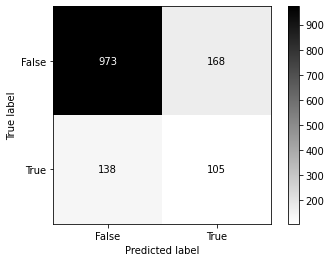

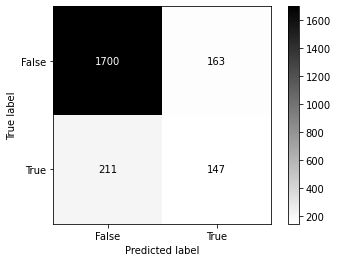

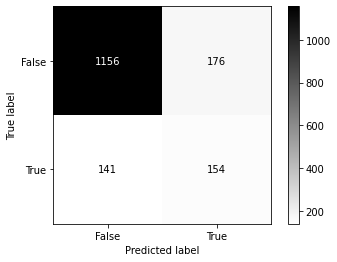

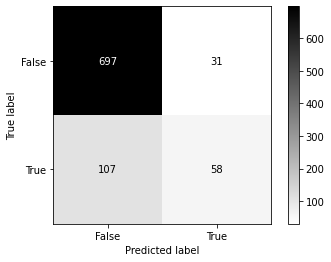

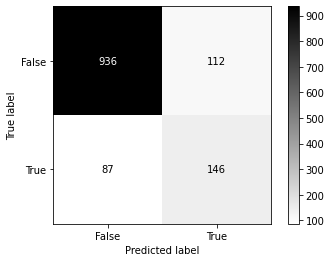

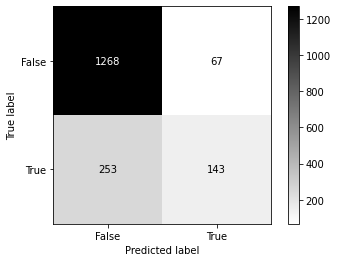

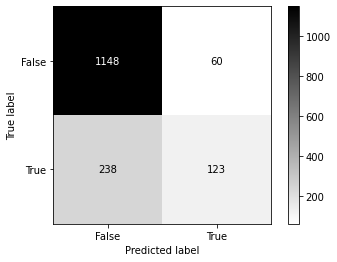

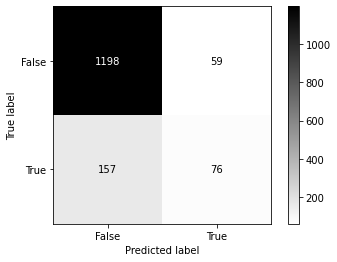

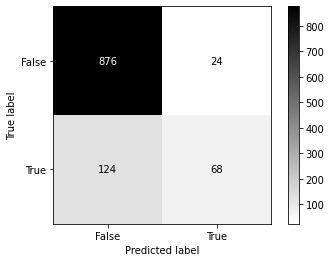

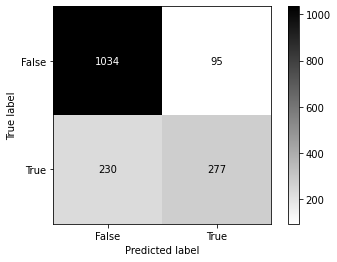

In [97]:
par_ens_scores, par_ens_dict = model_utils.get_report_from_splits(full_par_db,"par")

In [98]:
par_ens_scores

[0.7838563298844815,
 0.826628209198503,
 0.8093213780482132,
 0.8261783955318779,
 0.8476698523586471,
 0.7927852438914719,
 0.7855135037897657,
 0.8384504683329528,
 0.84417435788822,
 0.7916931694734353]

In [99]:
np.mean(par_ens_scores)

0.8146270908397568

In [1]:
np.median(par_ens_scores)

NameError: name 'np' is not defined

### Get score via MySegEval

In [30]:
imp.reload(classes)
imp.reload(common_utils)
imp.reload(model_utils)

<module 'model_utils' from './src/model_utils.py'>

Split 0
              precision    recall  f1-score   support

      is_nar       0.73      0.47      0.57       781
     not_nar       0.86      0.95      0.90      2597

    accuracy                           0.84      3378
   macro avg       0.79      0.71      0.73      3378
weighted avg       0.83      0.84      0.82      3378

MySegEval init called
Split 1
              precision    recall  f1-score   support

      is_nar       0.70      0.58      0.63      1045
     not_nar       0.86      0.91      0.88      2911

    accuracy                           0.82      3956
   macro avg       0.78      0.74      0.76      3956
weighted avg       0.81      0.82      0.82      3956

MySegEval init called
Split 2
              precision    recall  f1-score   support

      is_nar       0.72      0.38      0.50       915
     not_nar       0.81      0.95      0.87      2498

    accuracy                           0.79      3413
   macro avg       0.76      0.66      0.68      3413
weight

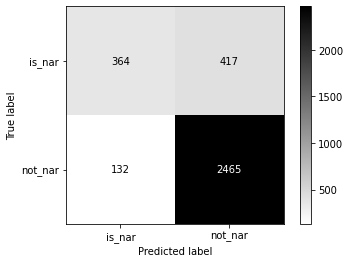

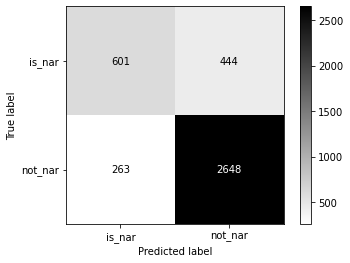

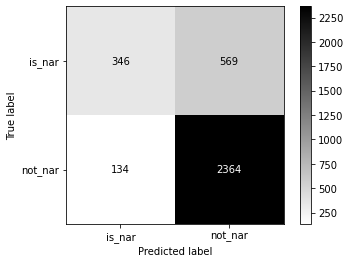

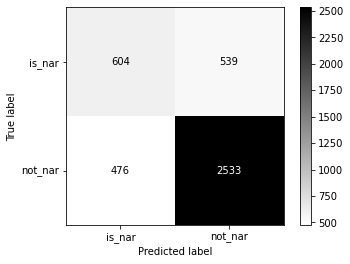

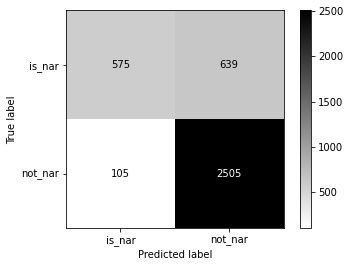

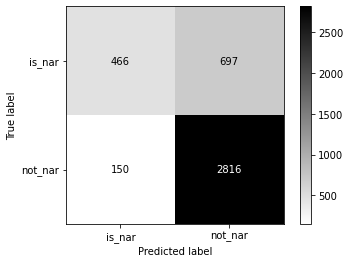

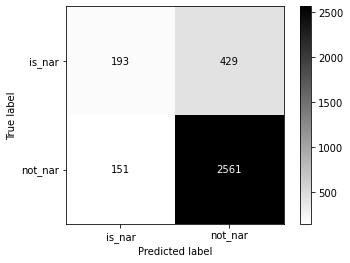

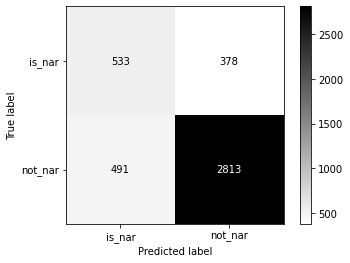

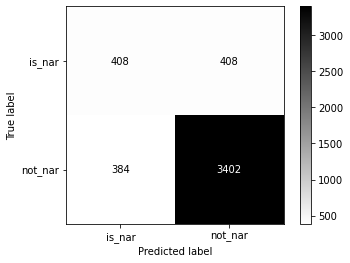

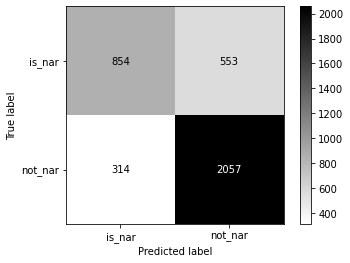

In [180]:
ens_scores, ens_dict = model_utils.get_report_from_splits(ens_crf_db,"ens")


In [181]:
ens_dict

{0: {'is_nar': {'precision': 0.7338709677419355,
   'recall': 0.4660691421254802,
   'f1-score': 0.5700861393891935,
   'support': 781},
  'not_nar': {'precision': 0.8553088133240805,
   'recall': 0.9491721216788602,
   'f1-score': 0.8997992334367586,
   'support': 2597},
  'accuracy': 0.8374777975133215,
  'macro avg': {'precision': 0.794589890533008,
   'recall': 0.7076206319021702,
   'f1-score': 0.734942686412976,
   'support': 3378},
  'weighted avg': {'precision': 0.8272321533478652,
   'recall': 0.8374777975133215,
   'f1-score': 0.8235689414145122,
   'support': 3378},
  'segeval': {'f1': Decimal('0.07772020725388601036269430053'),
   'recall': Decimal('0.04043126684636118598382749326'),
   'precision': Decimal('0.04043126684636118598382749326'),
   'b_sim': Decimal('0.03947368421052631578947368421'),
   's_sim': Decimal('0.9459579508439443292863488303')}},
 1: {'is_nar': {'precision': 0.6956018518518519,
   'recall': 0.5751196172248804,
   'f1-score': 0.6296490309062337,
   's

In [182]:
for k,split in ens_dict.items():
    print(k)
    print('b_sim',split['segeval']['b_sim'])
    print('s_sim',split['segeval']['s_sim'])
    print('f1',split['weighted avg']['f1-score'])

0
b_sim 0.03947368421052631578947368421
s_sim 0.9459579508439443292863488303
f1 0.8235689414145122
1
b_sim 0.06377551020408163265306122449
s_sim 0.9536030341340075853350189633
f1 0.8155060224140532
2
b_sim 0.05853658536585365853658536585
s_sim 0.9434349355216881594372801876
f1 0.7701570841084444
3
b_sim 0.04275092936802973977695167286
s_sim 0.9379667549987954709708503975
f1 0.7533418061200589
4
b_sim 0.06185567010309278350515463918
s_sim 0.9523934083180748103583573110
f1 0.7870399252585586
5
b_sim 0.04366812227074235807860262009
s_sim 0.9469476744186046511627906977
f1 0.7719880204096858
6
b_sim 0.07371794871794871794871794872
s_sim 0.9566456645664566456645664566
f1 0.8052433538381047
7
b_sim 0.06734693877551020408163265306
s_sim 0.9457759848125296630280018984
f1 0.7980580003505959
8
b_sim 0.04838709677419354838709677419
s_sim 0.9615301021517061508367746142
f1 0.8268884695942913
9
b_sim 0.05761316872427983539094650206
s_sim 0.9393698702674079957638337305
f1 0.7653691919842102


### Calculate SegEval for ground truth vs random segmentation

In [183]:
y_true=ens_crf_db.query('ens_group==4')['ens_true'].tolist()
len(y_true)

471

In [184]:
random_idx = random.randint(1,80)
random_idx

32

In [185]:
y_rand=ens_crf_db.query('ens_group==@random_idx')['ens_predicted'].tolist()
len(y_rand)

441

In [186]:
y_pred=y_rand+y_rand
y_pred=y_pred[:len(y_true)]
len(y_pred)

471

In [187]:
imp.reload(classes)
imp.reload(model_utils)
score, output_dict=common_utils.get_report(y_true,y_pred,np.unique(y_true))
score, output_dict

MySegEval init called


(0.7256390222842976,
 {'is_nar': {'precision': 0.78125,
   'recall': 0.43352601156069365,
   'f1-score': 0.5576208178438662,
   'support': 173},
  'not_nar': {'precision': 0.7386666666666667,
   'recall': 0.9295302013422819,
   'f1-score': 0.8231797919762258,
   'support': 298},
  'accuracy': 0.7473460721868365,
  'macro avg': {'precision': 0.7599583333333333,
   'recall': 0.6815281064514878,
   'f1-score': 0.690400304910046,
   'support': 471},
  'weighted avg': {'precision': 0.754307678697806,
   'recall': 0.7473460721868365,
   'f1-score': 0.7256390222842976,
   'support': 471},
  'segeval': {'f1': 0,
   'recall': 0,
   'precision': 0,
   'b_sim': Decimal('0'),
   's_sim': Decimal('0.9489361702127659574468085106')}})

In [178]:

print(model_utils.get_colored_from_list(y_true,'is_nar',html=False))
print(model_utils.get_colored_from_list(y_pred,'is_nar',html=False))

000|001|002|003|004|005|006|007|008|009|010|011|012|013|014|015|016|017|018|019|020|021|022|023|024|025|026|027|028|029|030|031|032|033|034|035|036|037|038|039|040|041|042|043|044|045|046|047|048|049|050|051|052|053|054|055|056|057|058|059|060|061|062|063|064|065|066|067|068|069|070|071|072|073|074|075|076|077|078|079|080|081|082|083|084|085|086|087|088|089|090|091|092|093|094|095|096|097|098|099|100|101|102|103|104|105|106|107|108|109|110|111|112|113|114|115|116|117|118|119|120|121|122|123|124|125|126|127|128|129|130|131|132|133|134|135|136|137|138|139|140|141|142|143|144|145|146|147|148|149|150|151|152|153|154|155|156|157|158|159|160|161|162|163|164|165|166|167|168|169|170|171|172|173|174|175|176|177|178|179|180|181|182|183|184|185|186|187|188|189|190|191|192|193|194|195|196|197|198|199|200|201|202|203|204|205|206|207|208|209|210|211|212|213|214|215|216|217|218|219|220|221|222|223|224|225|226|227|228|229|230|231|232|233|234|235|236|237|238|239|240|241|242|243|244|245|246|247|248|249|

### Print true vs predicted sentence indices

In [59]:
imp.reload(model_utils)
_list=[0,1,0]
my_str=model_utils.get_colored_from_list(_list)

In [60]:
y_true=ens_crf_db.query('ens_group==4')['ens_true'].tolist()
y_pred=ens_crf_db.query('ens_group==4')['ens_predicted'].tolist()

In [64]:
imp.reload(model_utils)
print(model_utils.get_colored_from_list(y_true,'is_nar'))
print(model_utils.get_colored_from_list(y_pred,'is_nar'))

000|001|002|003|004|005|006|007|008|009|010|011|012|013|014|015|016|017|018|019|020|021|022|023|024|025|026|027|028|029|030|031|032|033|034|035|036|037|038|039|040|041|042|043|044|045|046|047|048|049|050|051|052|053|054|055|056|057|058|059|060|061|062|063|064|065|066|067|068|069|070|071|072|073|074|075|076|077|078|079|080|081|082|083|084|085|086|087|088|089|090|091|092|093|094|095|096|097|098|099|100|101|102|103|104|105|106|107|108|109|110|111|112|113|114|115|116|117|118|119|120|121|122|123|124|125|126|127|128|129|130|131|132|133|134|135|136|137|138|139|140|141|142|143|144|145|146|147|148|149|150|151|152|153|154|155|156|157|158|159|160|161|162|163|164|165|166|167|168|169|170|171|172|173|174|175|176|177|178|179|180|181|182|183|184|185|186|187|188|189|190|191|192|193|194|195|196|197|198|199|200|201|202|203|204|205|206|207|208|209|210|211|212|213|214|215|216|217|218|219|220|221|222|223|224|225|226|227|228|229|230|231|232|233|234|235|236|237|238|239|240|241|242|243|244|245|246|247|248|249|

In [66]:
estimator="ens"
for group in ens_crf_db["{}_group".format(estimator)].unique():
    y_true=ens_crf_db.query('{}_group==@group'.format(estimator))['{}_true'.format(estimator)].tolist()
    y_pred=ens_crf_db.query('{}_group==@group'.format(estimator))['{}_predicted'.format(estimator)].tolist()
    print(model_utils.get_colored_from_list(y_true,'is_nar'))
    print(model_utils.get_colored_from_list(y_pred,'is_nar'))

000|001|002|003|004|005|006|007|008|009|010|011|012|013|014|015|016|017|018|019|020|021|022|023|024|025|026|027|028|029|030|031|032|033|034|035|036|037|038|039|040|041|042|043|044|045|046|047|048|049|050|051|052|053|054|055|056|057|058|059|060|061|062|063|064|065|066|067|068|069|070|071|072|073|074|075|076|077|078|079|080|081|082|083|084|085|086|087|088|089|090|091|092|093|094|095|096|097|098|099|100|101|102|103|104|105|106|107|108|109|110|111|112|113|114|115|116|117|118|119|120|121|122|123|124|125|126|127|128|129|130|131|132|133|134|135|136|137|138|139|140|141|142|143|144|145|146|147|148|149|150|151|152|153|154|155|156|157|158|159|160|161|162|163|164|165|166|167|168|169|170|171|172|173|174|175|176|177|178|179|180|181|182|183|184|185|186|187|188|189|190|191|192|193|194|195|196|197|198|199|200|201|202|203|204|205|206|207|208|209|210|211|212|213|214|215|216|217|218|219|220|221|222|223|224|225|226|227|228|229|230|231|232|233|234|235|236|237|238|239|240|241|242|243|244|245|246|247|248|249|

000|001|002|003|004|005|006|007|008|009|010|011|012|013|014|015|016|017|018|019|020|021|022|023|024|025|026|027|028|029|030|031|032|033|034|035|036|037|038|039|040|041|042|043|044|045|046|047|048|049|050|051|052|053|054|055|056|057|058|059|060|061|062|063|064|065|066|067|068|069|070|071|072|073|074|075|076|077|078|079|080|081|082|083|084|085|086|087|088|089|090|091|092|093|094|095|096|097|098|099|100|101|102|103|104|105|106|107|108|109|110|111|112|113|114|115|116|117|118|119|120|121|122|123|124|125|126|127|128|129|130|131|132|133|134|135|136|137|138|139|140|141|142|143|144|145|146|147|148|149|150|151|152|153|154|155|156|157|158|159|160|161|162|163|164|165|166|167|168|169|170|171|172|173|174|175|176|177|178|179|180|181|182|183|184|185|186|187|188|189|190|191|192|193|194|195|196|197|198|199|200|201|202|203|204|205|206|207|208|209|210|211|212|213|214|215|216|217|218|219|220|221|222|223|224|225|226|227|228|229|230|231|232|233|234|235|236|237|238|239|240|241|242|243|244|245|246|247|248|249|

In [74]:
y_true

['not_nar',
 'not_nar',
 'not_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'not_nar',
 'not_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'is_nar',
 'is_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'is_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'is_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'not_nar',
 'is_

In [146]:
imp.reload(model_utils)
imp.reload(classes)

try_db=pd.DataFrame(columns=['true','pred'])
try_db.loc[0,'true']=model_utils.get_colored_from_list(y_true,'is_nar')
try_db.loc[0,'pred']=model_utils.get_colored_from_list(y_pred,'is_nar')

In [147]:
try_db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 0 to 0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   true    1 non-null      object
 1   pred    1 non-null      object
dtypes: object(2)
memory usage: 132.0+ bytes


In [156]:
imp.reload(classes)
doc=classes.Document(1,"")
doc.print_df=try_db.copy()
doc.write_html("try",index=False,style="numeric_style")

### Collect statistic on paragraphs